# Scalability and Processing Time
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate the scalability and processing time of our structural preservation metrics. A dataset from the [UMAP _Nat. Biotech._ paper (Becht, _et al._ 2018)](https://www.nature.com/articles/nbt.4314) is evaluated:__

Mouse Cell Atlas Hematopoeitic Dataset [GSE108097](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108097)

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
%time hemato = sc.read('../inputs/mca_hemato.h5ad') # read in MCA hemato scRNA-seq data

CPU times: user 11.5 s, sys: 2.08 s, total: 13.6 s
Wall time: 13.7 s


---
### Downsample `Obs` and `Var`
Our dataset has __>45k cells__ and __>25k gene features__.

Let's downsample to __10k cells__ and perform a __500-component PCA__ to serve as _native space_ (input to downstream dimension-reduction method(s)).

In [3]:
sc.pp.subsample(data=hemato, n_obs=10000, random_state=18) # random sample of 10k cells inplace
hemato

AnnData object with n_obs × n_vars = 10000 × 25411 
    obs: 'batch'

Perform standard preprocessing of `AnnData` object:

In [4]:
%%time
# raw
hemato.layers['raw_counts'] = hemato.X.copy() # store raw counts before manipulation
# obs/var
hemato.var['mito'] = hemato.var_names.str.contains('mt-') # identify mitochondrial genes
sc.pp.calculate_qc_metrics(hemato, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# normalize/transform
sc.pp.normalize_total(hemato, target_sum=10000, layers=None, layer_norm=None, key_added='norm_factor')
sc.pp.log1p(hemato) # log1p transform counts
# HVGs
sc.pp.highly_variable_genes(hemato, flavor='seurat', n_top_genes=2000)

CPU times: user 5.41 s, sys: 910 ms, total: 6.32 s
Wall time: 6.33 s


In [5]:
%%time
sc.pp.scale(hemato, max_value=10)
sc.tl.pca(hemato, use_highly_variable=False, n_comps=500)

CPU times: user 1min 21s, sys: 4.29 s, total: 1min 26s
Wall time: 15.1 s


In [6]:
# create neighborhood graphs from PCA results and perform louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(hemato, n_neighbors=100, use_rep='X_pca', n_pcs=500, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(hemato, resolution=1.0, key_added='louvain', random_state=18, copy=False)
hemato.obs['clusterID'] = 'cluster_' + hemato.obs['louvain'].astype(str)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

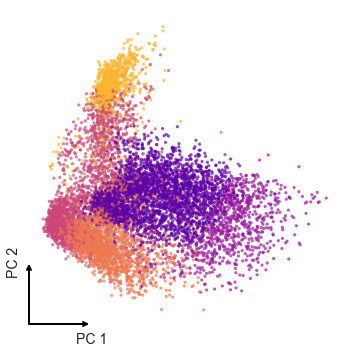

In [7]:
DR_plot(dim_name='PC').plot_IDs(hemato, use_rep='X_pca', obs_col='clusterID', pt_size=10)

In [8]:
%time sc.tl.umap(hemato, random_state=18)

CPU times: user 27.7 s, sys: 318 ms, total: 28.1 s
Wall time: 26.4 s


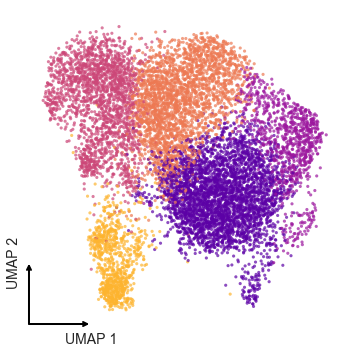

In [9]:
DR_plot(dim_name='UMAP').plot_IDs(hemato, use_rep='X_umap', obs_col='clusterID', pt_size=10)

In [10]:
%%time
# save distance matrices in AnnData object for easy access
hemato.uns['umap_distance'] = pdist(hemato.obsm['X_umap'])
hemato.uns['pca_distance'] = pdist(hemato.obsm['X_pca'])

CPU times: user 24.1 s, sys: 192 ms, total: 24.3 s
Wall time: 24.3 s


In [11]:
time_1k = %timeit -n 3 -r 3 -o distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=499500) # 1000 cells

2.5 s ± 12.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [12]:
time_2k = %timeit -n 3 -r 3 -o distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=1999000) # 2000 cells

3.06 s ± 22.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [13]:
time_4k = %timeit -n 3 -r 3 -o distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=7998000) # 4000 cells

6.01 s ± 20.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [14]:
time_6k = %timeit -n 3 -r 3 -o distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=17997000) # 6000 cells

11.6 s ± 46.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [15]:
time_8k = %timeit -n 3 -r 3 -o distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=31996000) # 8000 cells

20.3 s ± 79.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [16]:
time_10k = %timeit -n 3 -r 3 -o distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=False) # 10000 cells

27.3 s ± 68.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [40]:
final = pd.DataFrame(np.stack([np.append(np.array(time_1k.all_runs)/time_1k.loops, [time_1k.average, time_1k.stdev]),
                               np.append(np.array(time_2k.all_runs)/time_2k.loops, [time_2k.average, time_2k.stdev]),
                               np.append(np.array(time_4k.all_runs)/time_4k.loops, [time_4k.average, time_4k.stdev]),
                               np.append(np.array(time_6k.all_runs)/time_6k.loops, [time_6k.average, time_6k.stdev]),
                               np.append(np.array(time_8k.all_runs)/time_8k.loops, [time_8k.average, time_8k.stdev]),
                               np.append(np.array(time_10k.all_runs)/time_10k.loops, [time_10k.average, time_10k.stdev])]
                             ), 
                     columns=['rep1','rep2','rep3','avg','sd']
                    )
final['n'] = [1000,2000,4000,6000,8000,10000]

In [41]:
final

,rep1,rep2,rep3,avg,sd,n
0,2.512788,2.499534,2.481483,2.497935,0.012830,1000
1,3.076836,3.070615,3.026268,3.057907,0.022516,2000
2,6.038585,6.004896,5.990731,6.011404,0.020071,4000
3,11.698903,11.592701,11.607636,11.633080,0.046942,6000
4,20.352515,20.205107,20.388561,20.315395,0.079361,8000
5,27.319039,27.434466,27.272335,27.341947,0.068143,10000


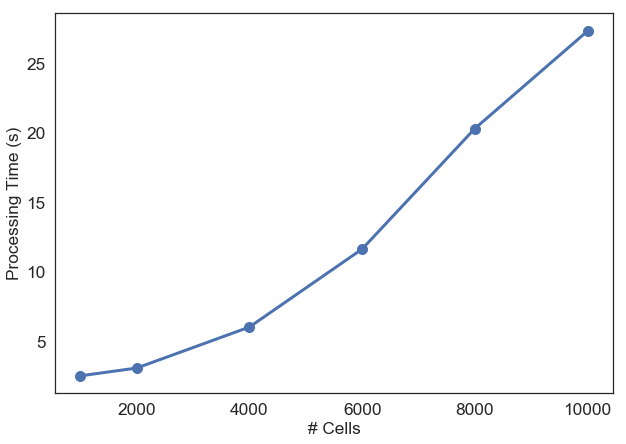

In [42]:
plt.figure(figsize=(10,7))
plt.errorbar('n', 'avg', 'sd', data=final, linewidth=3, fmt='bo-', markersize=10)
plt.xlabel('# Cells', fontsize='xx-large')
plt.ylabel('Processing Time (s)', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.show()